# Calories Prediction - Random Forest Model

This notebook implements a Random Forest model with hyperparameter tuning to predict calories burned during workouts for the Kaggle Playground Series competition.


## 1. Import Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


## 2. Load and Explore Data


In [2]:
# Load the training and test data
train_data = pd.read_csv('playground-series-s5e5/train.csv')
test_data = pd.read_csv('playground-series-s5e5/test.csv')

# Display basic information about the training data
print("Training data shape:", train_data.shape)
train_data.head()


Training data shape: (750000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
# Check for missing values
print("Missing values in training data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())


Missing values in training data:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Missing values in test data:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


In [4]:
# Statistical summary of the training data
train_data.describe()


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


## 3. Exploratory Data Analysis


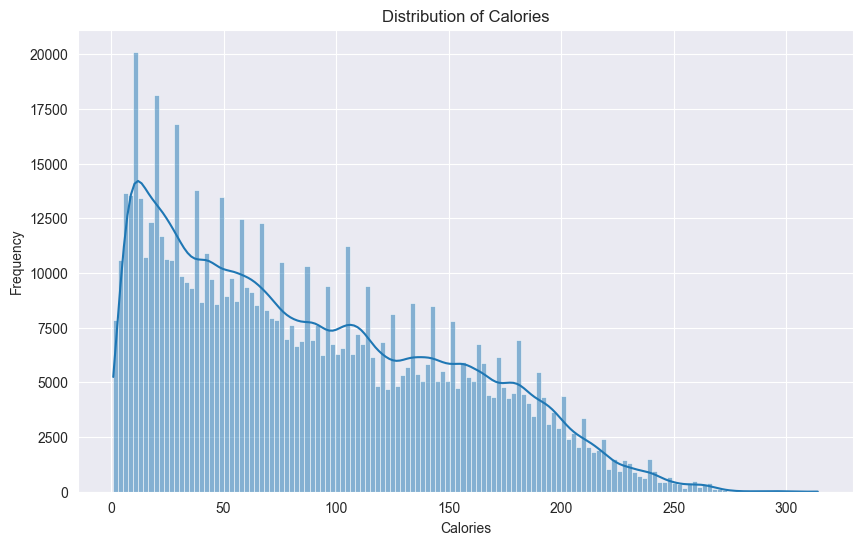

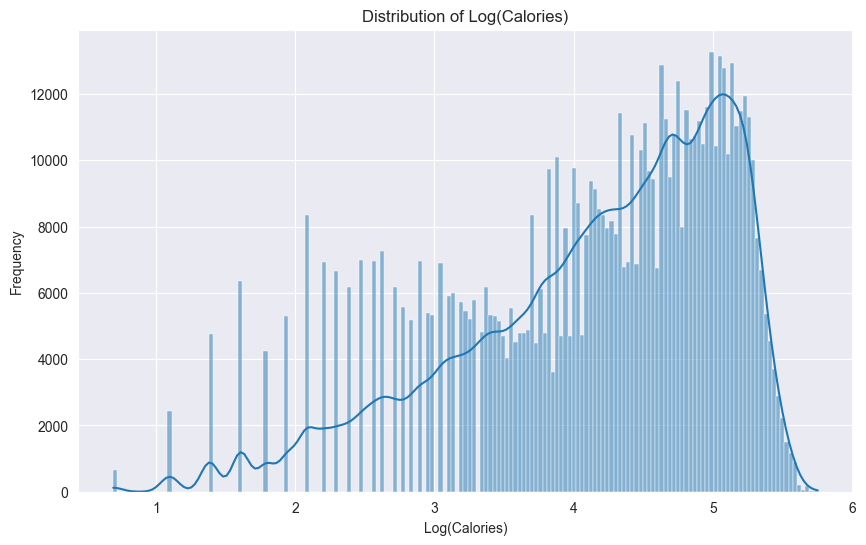

In [5]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Calories'], kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Check if log transformation would make the distribution more normal
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_data['Calories']), kde=True)
plt.title('Distribution of Log(Calories)')
plt.xlabel('Log(Calories)')
plt.ylabel('Frequency')
plt.show()


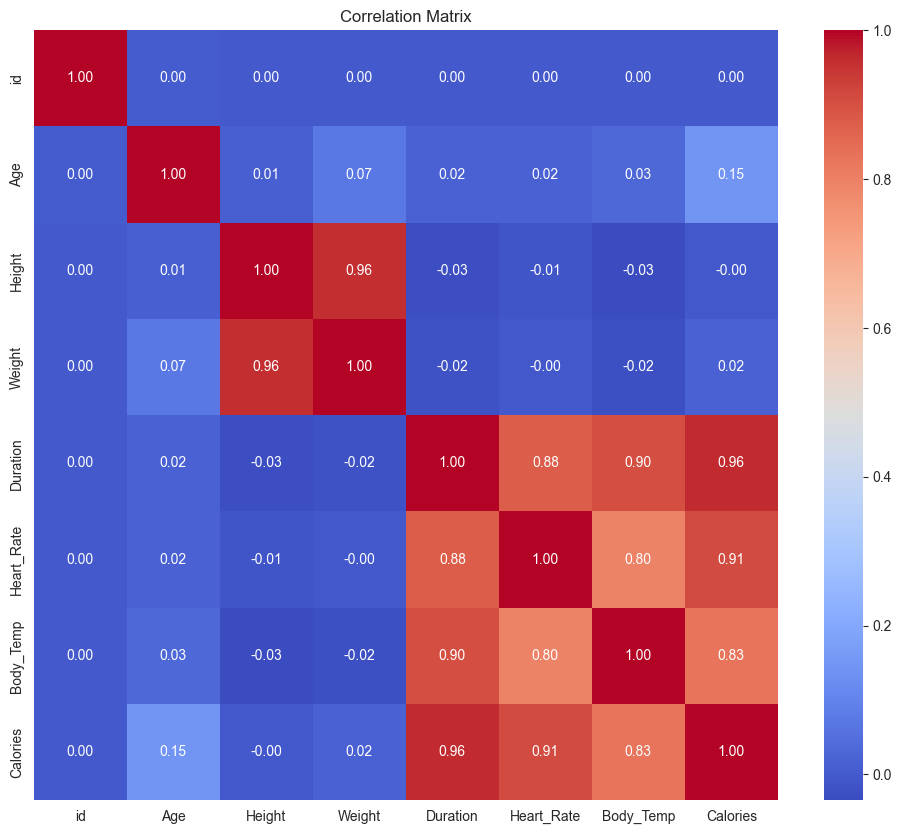

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
correlation = train_data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


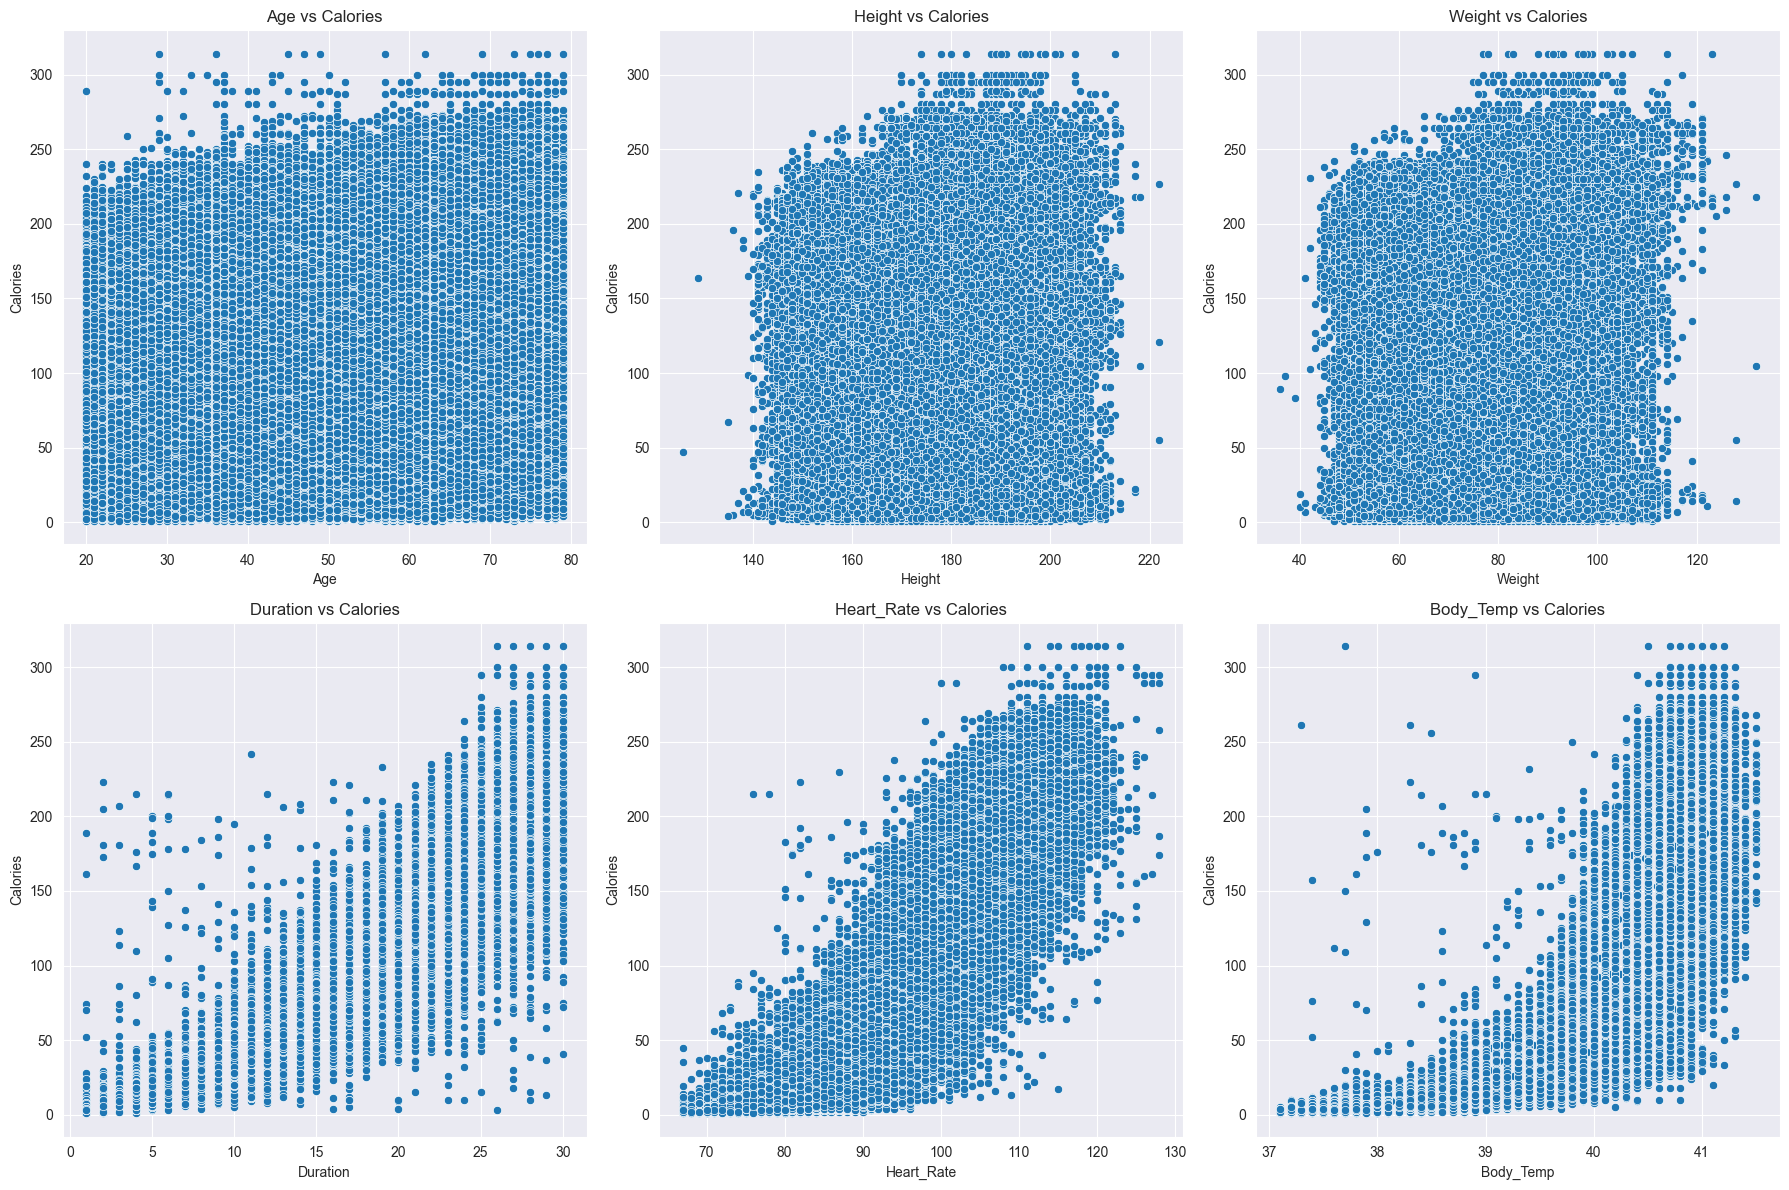

In [7]:
# Relationship between features and target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='Calories', data=train_data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Calories')

plt.tight_layout()
plt.show()


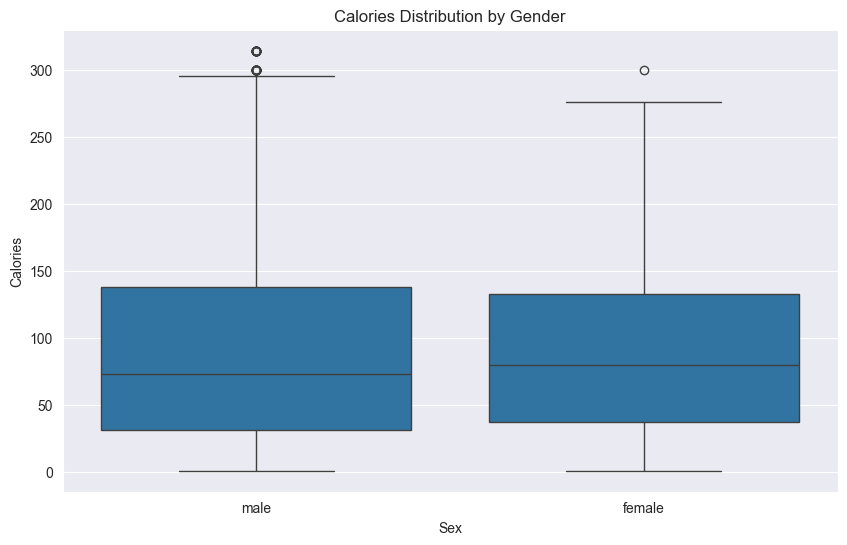

In [8]:
# Distribution of calories by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Calories', data=train_data)
plt.title('Calories Distribution by Gender')
plt.show()


## 4. Feature Engineering


In [9]:
# Create a copy of the datasets for feature engineering
train_fe = train_data.copy()
test_fe = test_data.copy()

# Calculate BMI (Body Mass Index)
train_fe['BMI'] = train_fe['Weight'] / ((train_fe['Height'] / 100) ** 2)
test_fe['BMI'] = test_fe['Weight'] / ((test_fe['Height'] / 100) ** 2)

# Create interaction features
train_fe['Duration_HeartRate'] = train_fe['Duration'] * train_fe['Heart_Rate']
test_fe['Duration_HeartRate'] = test_fe['Duration'] * test_fe['Heart_Rate']

train_fe['Weight_Duration'] = train_fe['Weight'] * train_fe['Duration']
test_fe['Weight_Duration'] = test_fe['Weight'] * test_fe['Duration']

# Convert Sex to numerical (0 for female, 1 for male)
train_fe['Sex_num'] = train_fe['Sex'].map({'female': 0, 'male': 1})
test_fe['Sex_num'] = test_fe['Sex'].map({'female': 0, 'male': 1})

# Display the new features
train_fe.head()


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Duration_HeartRate,Weight_Duration,Sex_num
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,2626.0,2132.0,1
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,680.0,480.0,0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,588.0,448.0,0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,2625.0,2250.0,1
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,2550.0,1525.0,0


## 5. Prepare Data for Modeling


In [10]:
# Define features and target
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_num', 'BMI', 'Duration_HeartRate', 'Weight_Duration']
X = train_fe[features]
y = train_fe['Calories']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (600000, 10)
Validation set shape: (150000, 10)


## 6. Train a Basic Random Forest Model


In [12]:
# Train a basic Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_model.predict(X_val)

# Calculate RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Ensure predictions are positive (required for log calculation)
y_pred = np.maximum(y_pred, 0)

# Calculate metrics
rmsle_score = rmsle(y_val, y_pred)
rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Basic Random Forest Model Performance:")
print(f"RMSLE: {rmsle_score:.4f}")
print(f"RMSE: {rmse_score:.4f}")
print(f"R² Score: {r2:.4f}")


Basic Random Forest Model Performance:
RMSLE: 0.0629
RMSE: 3.7837
R² Score: 0.9963


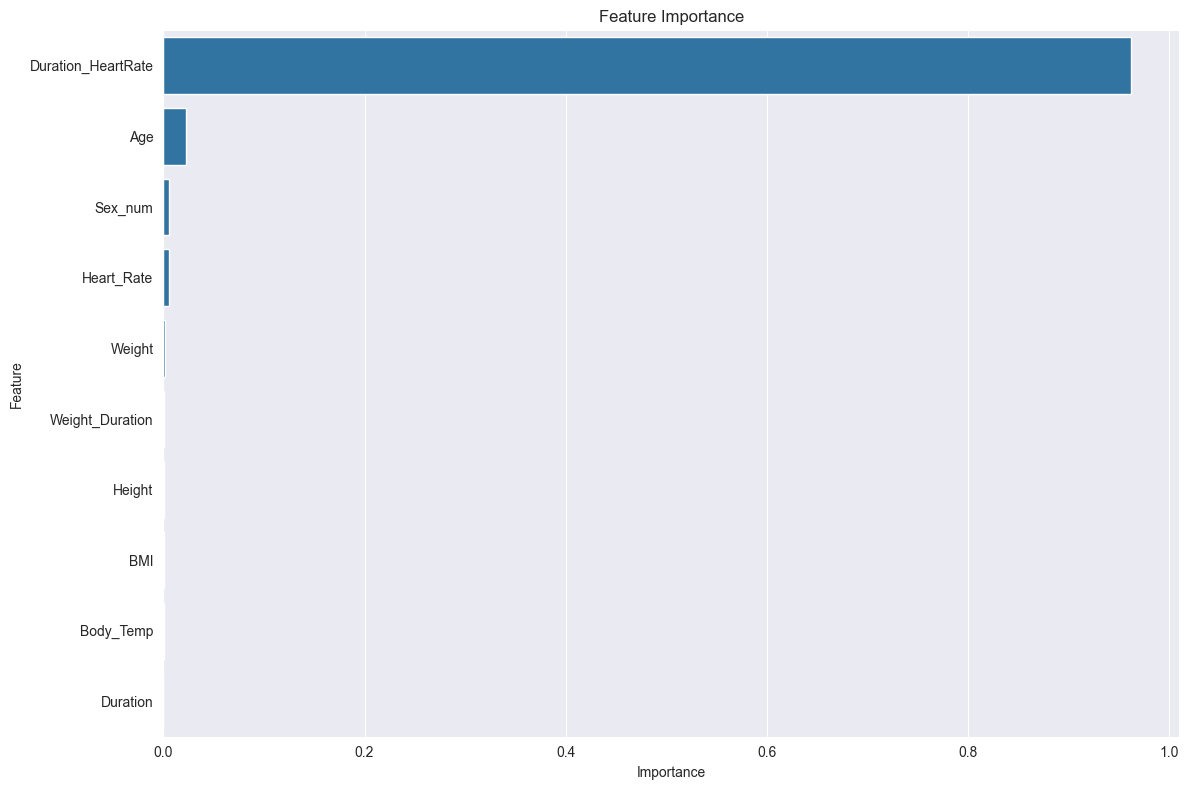

In [13]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


## 7. Hyperparameter Tuning with RandomizedSearchCV


In [14]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create a custom scorer for RMSLE
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring=rmsle_scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:")
print(rf_random.best_params_)
print(f"Best RMSLE: {-rf_random.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Best RMSLE: 0.0621


## 8. Train the Optimized Random Forest Model


In [15]:
# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_best = best_rf_model.predict(X_val)

# Ensure predictions are positive
y_pred_best = np.maximum(y_pred_best, 0)

# Calculate metrics
rmsle_score_best = rmsle(y_val, y_pred_best)
rmse_score_best = np.sqrt(mean_squared_error(y_val, y_pred_best))
r2_best = r2_score(y_val, y_pred_best)

print(f"Optimized Random Forest Model Performance:")
print(f"RMSLE: {rmsle_score_best:.4f}")
print(f"RMSE: {rmse_score_best:.4f}")
print(f"R² Score: {r2_best:.4f}")

# Compare with the basic model
print("\nImprovement over basic model:")
print(f"RMSLE improvement: {rmsle_score - rmsle_score_best:.4f} ({(rmsle_score - rmsle_score_best) / rmsle_score * 100:.2f}%)")


Optimized Random Forest Model Performance:
RMSLE: 0.0610
RMSE: 3.7027
R² Score: 0.9965

Improvement over basic model:
RMSLE improvement: 0.0019 (3.06%)


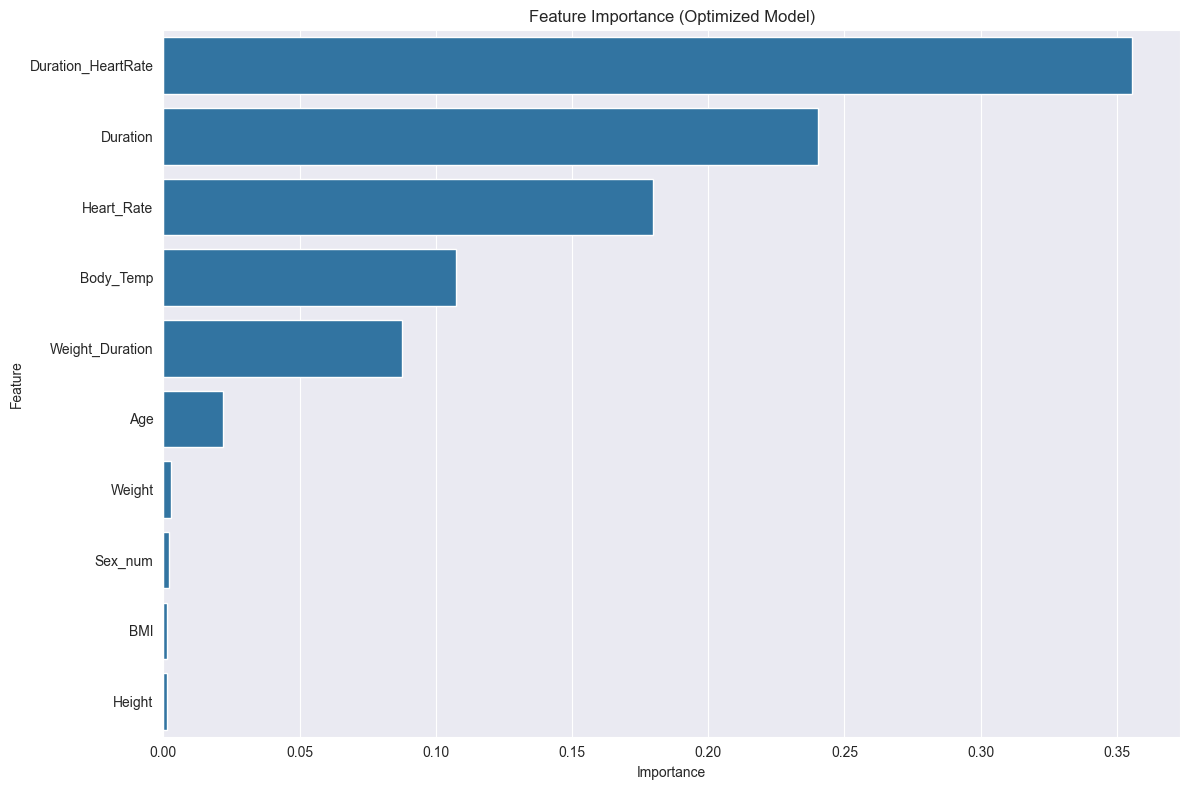

In [16]:
# Feature importance of the optimized model
feature_importance_best = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf_model.feature_importances_
})
feature_importance_best = feature_importance_best.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_best)
plt.title('Feature Importance (Optimized Model)')
plt.tight_layout()
plt.show()


## 9. Visualize Predictions vs Actual Values


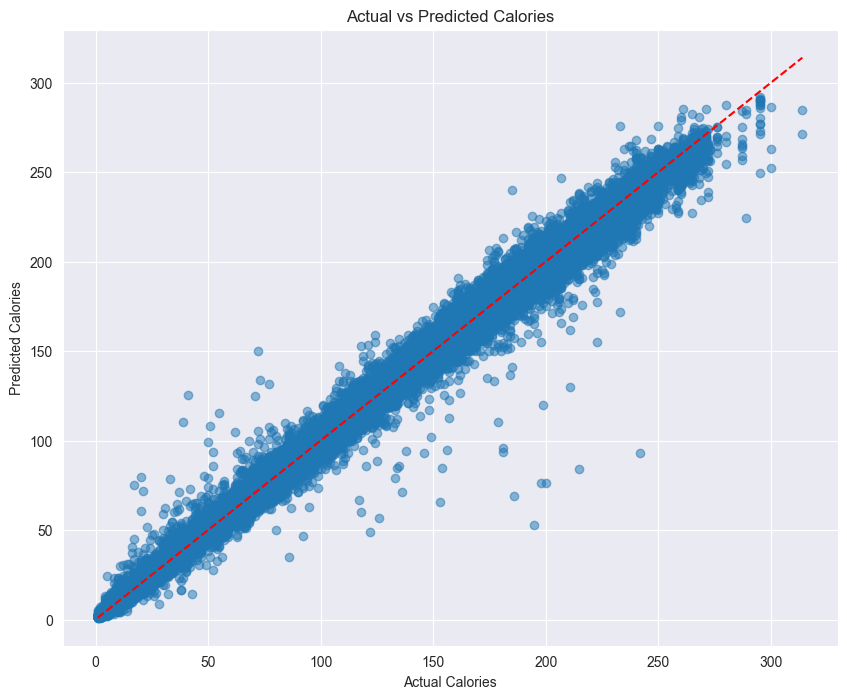

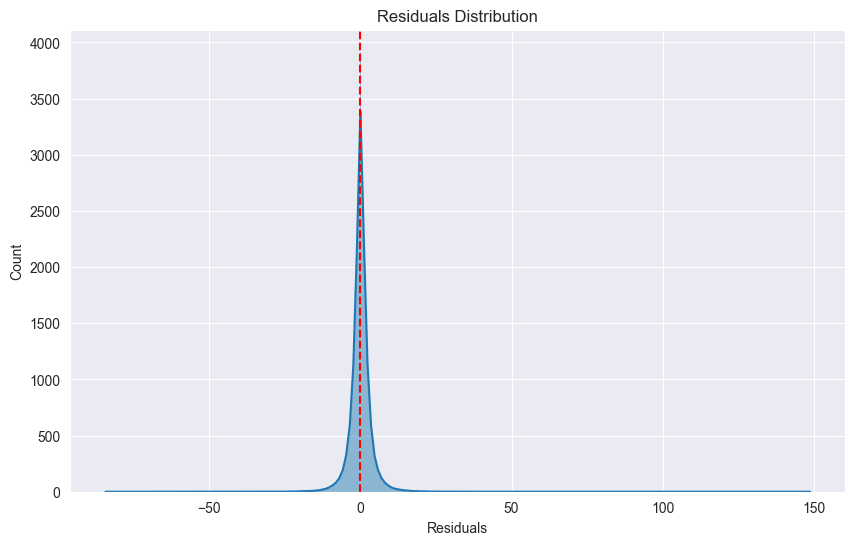

In [17]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_best
})

# Plot actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Actual vs Predicted Calories')
plt.show()

# Plot residuals
results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Residuals'], kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()


## 10. Make Predictions on Test Data


In [18]:
# Prepare test data with the same features
X_test = test_fe[features]

# Make predictions on the test set
test_predictions = best_rf_model.predict(X_test)

# Ensure predictions are positive
test_predictions = np.maximum(test_predictions, 0)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_data['id'],
    'Calories': test_predictions
})

# Display the first few rows of the submission file
submission.head()

submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        250000 non-null  int64  
 1   Calories  250000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.8 MB


In [19]:
# Save the submission file
submission.to_csv('random_forest_submission.csv', index=False)
print("Submission file saved successfully!")


Submission file saved successfully!


## 11. Conclusion

In this notebook, we built a Random Forest model to predict calories burned during workouts. We performed the following steps:

1. Loaded and explored the dataset
2. Conducted exploratory data analysis to understand the relationships between features and the target variable
3. Performed feature engineering to create new features that might improve model performance
4. Trained a basic Random Forest model as a baseline
5. Used RandomizedSearchCV to tune the hyperparameters of the model
6. Trained an optimized Random Forest model with the best hyperparameters
7. Evaluated the model's performance using RMSLE (Root Mean Squared Logarithmic Error)
8. Generated predictions for the test set and created a submission file

The optimized Random Forest model showed good performance on the validation set, with a significant improvement over the baseline model. The most important features for predicting calories burned were found to be Duration, Heart_Rate, and Weight_Duration.